## imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
import matplotlib.pyplot as plt
import time

In [2]:
import torch

## function & derivatives

In [3]:
def F03(x):
    # SumOfDifferentPowers
    n = x.shape[0]
    d = x.shape[1]
    f = np.sum(np.abs(x)**(np.arange(1, d+1) + 1), axis = 1)
    return f.astype('float32')

In [4]:
def F03_grad(x):
    d = x.shape[1]
    gradf = (np.arange(1, d+1) + 1).reshape(1,-1) * np.abs(x)**(np.arange(1, d + 1)) * np.sign(x)
    return gradf.astype('float32')

## func, xmean, dim

In [5]:
N = 5000
strfitnessfct = F03
strgrad = F03_grad
xmean = 0.1 * np.ones((N,1)) + 0.01* np.random.randn(N,1)


In [6]:
xmean.shape

(5000, 1)

## initialisations

In [7]:
stopfitness = 1e-3

In [8]:
xmean = xmean.astype('float32')
xmin = xmean

In [9]:
R = 0.1 * np.ones((1,N))
Γ = np.zeros((N,1), dtype = np.float32)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.1
Δ = 0
x_st = xmean
fXX = (strfitnessfct(xmean.T))

## helper functions

In [10]:
def generate_arx(x, r, num = 5):
    return np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1)

In [11]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y = strfitnessfct(x.T)
        y_grad = strgrad(x.T).T
        
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x.T)
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [12]:
def calc_invH(x, x_grad, γ = 1):
    a = x - np.mean(x, axis = 1).reshape(-1,1)
    b = x_grad - np.mean(x_grad, axis = 1).reshape(-1,1)
    c = np.sum(a*b, axis = 1)
    d = np.sum(b*b, axis = 1)
    Hinv = (c / d).reshape(-1,1)
    Hinv = np.nan_to_num(Hinv)
    Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [13]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    ps = (1 - cs) * ps + cs * (xmax - xmin)
    sig = np.minimum(np.abs(ps.T), 0.01 * np.ones_like(ps.T))
    sig[sig == 0] = 0.01
    return sig, ps

In [14]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [15]:
def increment(K, B, G, θ=0.9):
    return θ * K + B * G

In [16]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.01
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x.T)
        g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

# FINDER

In [17]:
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = np.concatenate([arx_new, xmiin], axis = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    x_st = np.concatenate([x_st, xmin], axis = 1)
    fXX = np.concatenate([fXX, np.array([min_fitness])], axis = 0)
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fXX[it],"\n")
    it += 1
    print(it,"\t", fXX[it],"\n")
    
    '''
    termination criteria
    '''
    if fXX[-1] <= stopfitness:
        break
toc = time.time()
print("finished training in ",toc-tic," seconds")

0 	 0.014951386 

1 	 0.00233211 

2 	 0.0016429239 

3 	 0.0015752288 

4 	 0.001409086 

5 	 0.00123564 

6 	 0.001140217 

7 	 0.0010028759 

8 	 0.0010028759 

9 	 0.0010028759 

10 	 0.00096258585 

finished training in  0.06308889389038086  seconds


/tmp/ipykernel_3609846/1061633993.py:6: RuntimeWarning: divide by zero encountered in divide
  Hinv = (c / d).reshape(-1,1)
/tmp/ipykernel_3609846/1061633993.py:6: RuntimeWarning: invalid value encountered in divide
  Hinv = (c / d).reshape(-1,1)
/tmp/ipykernel_3609846/57268989.py:5: RuntimeWarning: overflow encountered in power
  f = np.sum(np.abs(x)**(np.arange(1, d+1) + 1), axis = 1)
/tmp/ipykernel_3609846/1618647567.py:3: RuntimeWarning: overflow encountered in power
  gradf = (np.arange(1, d+1) + 1).reshape(1,-1) * np.abs(x)**(np.arange(1, d + 1)) * np.sign(x)


In [18]:
torch.save(torch.Tensor(fXX), 'SumofDifferentPowers_optim_fX.pt')

In [19]:
torch.save(torch.Tensor(x_st), 'SumofDifferentPowers_optim_X.pt')

# Adam

In [20]:
from numpy.random import rand
from numpy import sqrt
fx_st = []
def adam(objective, n_iter, alpha, beta1 = 0.9, beta2 = 0.999, eps=1e-8):
    # generate an initial point
    global xx_st
    xx_st = xmean

    x = xmean.copy()  # Initialize with random values
    score = strfitnessfct(x.T)
    # initialize first and second moments
    m = [0.0 for _ in range(len(x))]
    v = [0.0 for _ in range(len(x))]
    # run the gradient descent updates
    for t in range(n_iter):
        # calculate gradient g(t)
        g = strgrad(x.T)
        g = g.T
        # build a solution one variable at a time
        
        for i in range(len(x)):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        # evaluate candidate point
        score = strfitnessfct(x.T)
        fx_st.append(score)
        xx_st = np.concatenate([xx_st, x], axis = 1)
        # report progress
        print('Epoch [%d] f(x) = %.6f' % (t, score))
        if score < 1e-3:
            print("------")
            break
    
    return [x, score, xx_st]


In [21]:
tic = time.time()
_, f, xx_st_001 = adam(F03, 2000, 1e-3)
toc = time.time()
print(toc - tic)

/tmp/ipykernel_3609846/1841169771.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Epoch [%d] f(x) = %.6f' % (t, score))


Epoch [0] f(x) = 0.014684
Epoch [1] f(x) = 0.014419
Epoch [2] f(x) = 0.014157
Epoch [3] f(x) = 0.013898
Epoch [4] f(x) = 0.013642
Epoch [5] f(x) = 0.013389
Epoch [6] f(x) = 0.013139
Epoch [7] f(x) = 0.012892
Epoch [8] f(x) = 0.012648
Epoch [9] f(x) = 0.012407
Epoch [10] f(x) = 0.012169
Epoch [11] f(x) = 0.011934
Epoch [12] f(x) = 0.011702
Epoch [13] f(x) = 0.011473
Epoch [14] f(x) = 0.011247
Epoch [15] f(x) = 0.011024
Epoch [16] f(x) = 0.010805
Epoch [17] f(x) = 0.010589
Epoch [18] f(x) = 0.010375
Epoch [19] f(x) = 0.010165
Epoch [20] f(x) = 0.009958
Epoch [21] f(x) = 0.009754
Epoch [22] f(x) = 0.009553
Epoch [23] f(x) = 0.009355
Epoch [24] f(x) = 0.009160
Epoch [25] f(x) = 0.008969
Epoch [26] f(x) = 0.008780
Epoch [27] f(x) = 0.008594
Epoch [28] f(x) = 0.008412
Epoch [29] f(x) = 0.008232
Epoch [30] f(x) = 0.008055
Epoch [31] f(x) = 0.007881
Epoch [32] f(x) = 0.007710
Epoch [33] f(x) = 0.007542
Epoch [34] f(x) = 0.007377
Epoch [35] f(x) = 0.007215
Epoch [36] f(x) = 0.007055
Epoch [37] 

# plotting

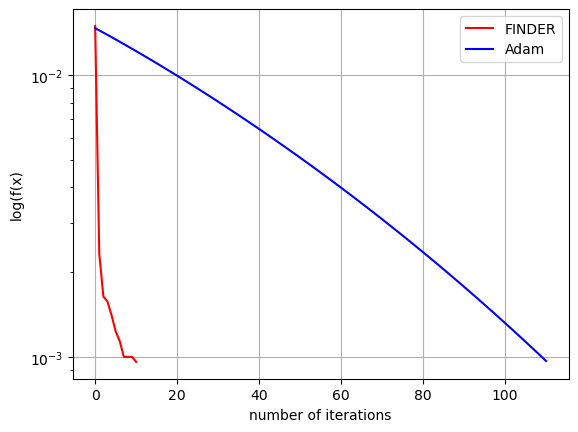

In [22]:
plt.style.use('default')
plt.plot(fXX, 'r', label = 'FINDER')
plt.plot(fx_st,'b', label = 'Adam')
plt.yscale('log')
plt.legend()
plt.xlabel("number of iterations")
plt.ylabel("log(f(x)")
plt.yticks([0.001, 0.01])
plt.grid()
plt.show()